<a href="https://colab.research.google.com/github/lipeng2021/-python1/blob/main/Kaggle_%E6%88%BF%E4%BB%B7%E9%A2%84%E6%B5%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#!pip install pandas
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from IPython import display
import sys
import time
import pandas as pd
torch.set_default_tensor_type(torch.FloatTensor)
FILENAME_TRAIN = '/train.csv'
FILENAME_TEST = '/test.csv'
import torch.nn.init as init
import matplotlib.pyplot as plt


In [30]:
train_data = pd.read_csv(FILENAME_TRAIN)
test_data = pd.read_csv(FILENAME_TEST)

In [31]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

预处理数据-数字处理，缺失值变均值

In [32]:
numeric_features = all_features.dtypes[all_features.dtypes !='object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
all_features = all_features.fillna(0)
all_features.iloc[0:3,4:7]

,Street,Alley,LotShape
0,Pave,0,Reg
1,Pave,0,Reg
2,Pave,0,IR1


预处理数据-离散数值转换成指示特征

In [33]:
all_features = pd.get_dummies(all_features,dummy_na=True)
print(all_features.shape)

(2919, 354)


将特征值转换成为NDArray方便后续的训练

In [34]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)
print(train_features.shape)
print(train_labels.shape)

torch.Size([1460, 354])
torch.Size([1460, 1])


训练模型

In [35]:
def get_net(feature_num):
  net = nn.Linear(feature_num,1)
  for param in net.parameters():
    init.normal_(param,mean=0,std=0.01)
  return net
loss = nn.MSELoss()

定义用来评价模型的对数均方根误差

In [36]:
def log_rmse(net,features,labels):
  with torch.no_grad():
    clipped_preds = torch.max(net(features),torch.tensor(1.0))
    rmse = torch.sqrt(2*loss(clipped_preds.log(),labels.log()).mean())
  return rmse.item()

In [37]:
def train_ch4(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
  train_loss = []
  test_loss = []
  dataset = torch.utils.data.TensorDataset(train_features,train_labels)
  train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
  optimizer = torch.optim.Adam(params=net.parameters(),lr=learning_rate,weight_decay=weight_decay)
  net= net.float()
  for epoch in range(num_epochs):
    for X,y in train_iter:
      l = loss(net(X.float()),y.float())
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
    train_loss.append(log_rmse(net,train_features,train_labels))
    if test_labels is not None:
      test_loss.append(log_rmse(net,test_features,test_labels))
  return train_loss,test_loss

K折交叉

In [38]:
def get_k_fold_data(k,i,X,y):
  assert k>1
  fold_size = X.shape[0]//k
  X_train =None
  y_train = None
  for j in range(k):
    idx = slice(j*fold_size,(j+1)*fold_size)
    X_part = X[idx,:]
    y_part = y[idx]
    if j==i:
      X_vaild = X_part
      y_vaild = y_part
    elif X_train is None:
      X_train = X_part
      y_train = y_part
    else:
      X_train = torch.cat((X_train,X_part),dim=0)
      y_train = torch.cat((y_train,y_part),dim=0)
  return X_train,y_train,X_vaild,y_vaild

In [58]:
def semilogy(x_vals,y_vals,x_labels,y_labels,x2_vals=None,y2_labels=None,legend=None,figsize=(12,12)):
  display.set_matplotlib_formats('svg')
  plt.rcParams['figure.figsize'] = figsize
  plt.semilogy(x_vals,y_vals)
  plt.xlabel(x_labels)
  plt.ylabel(y_labels)
  if x2_vals and y2_labels:
    plt.semilogy(x2_vals,y2_labels,linestyle=':')
    plt.legend(legend)

进行K折训练并且返回训练结果

In [47]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
  train_loss_sum = 0.0
  vaild_loss_sum = 0.0
  for i in range(k):
    data = get_k_fold_data(k,i,X_train,y_train)
    net = get_net(X_train.shape[1])
    train_loss,vaild_loss = train_ch4(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
    train_loss_sum += train_loss[-1]
    vaild_loss_sum += vaild_loss[-1]
    if i==0:
      semilogy(range(1,num_epochs+1),train_loss,'epochs','rmse',range(1,num_epochs+1),vaild_loss,['train','vaild'])
    print('fold:%d,train_RMSE:%f,vaild_RMSE:%f'%(i,train_loss[-1],vaild_loss[-1]))
  return train_loss_sum/k,vaild_loss_sum/k

进行训练

fold:0,train_RMSE:0.239914,vaild_RMSE:0.221562
fold:1,train_RMSE:0.229912,vaild_RMSE:0.272153
fold:2,train_RMSE:0.231834,vaild_RMSE:0.238619
fold:3,train_RMSE:0.237372,vaild_RMSE:0.218703
fold:4,train_RMSE:0.230621,vaild_RMSE:0.258052
5-fold vaildation:avg train RMSE 0.233930,avg vaild RMSE 0.241818


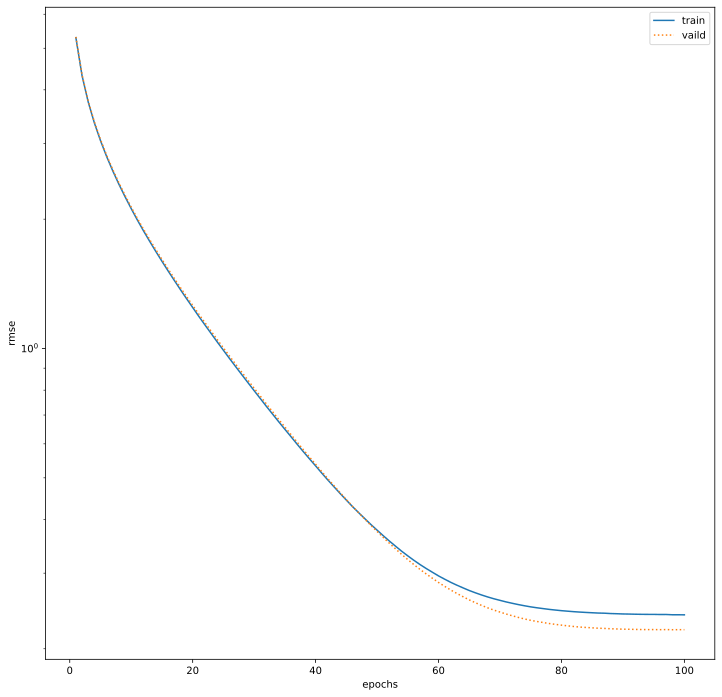

In [59]:
k = 5
num_epochs = 100
lr = 5
weight_decay = 0
batch_size = 64
train_loss,vaild_loss = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold vaildation:avg train RMSE %f,avg vaild RMSE %f'%(k,train_loss,vaild_loss))

fold:0,train_RMSE:0.239111,vaild_RMSE:0.222397
fold:1,train_RMSE:0.228464,vaild_RMSE:0.281342
fold:2,train_RMSE:0.230375,vaild_RMSE:0.234714
fold:3,train_RMSE:0.234517,vaild_RMSE:0.217926
fold:4,train_RMSE:0.229022,vaild_RMSE:0.257189
5-fold vaildation:avg train RMSE 0.232298,avg vaild RMSE 0.242714


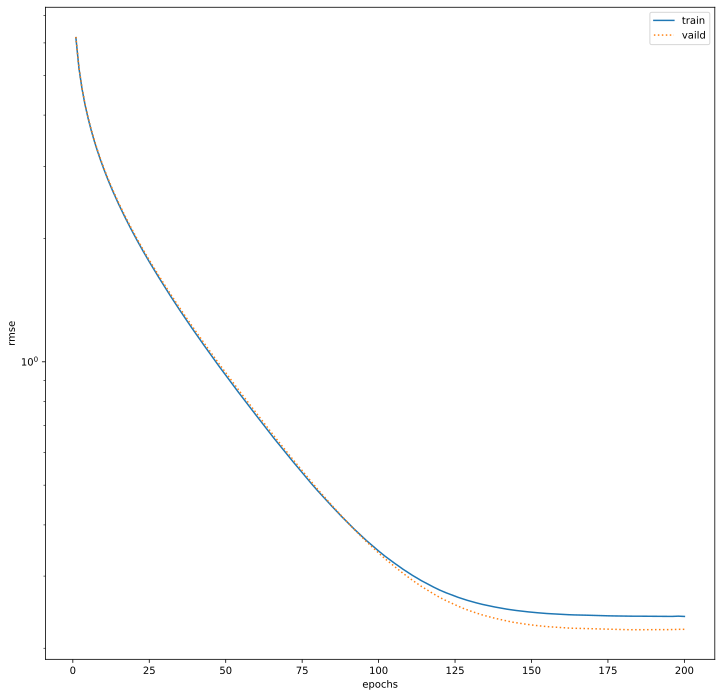

In [69]:
k = 5
num_epochs = 200
lr = 5
weight_decay = 0
batch_size = 128
train_loss,vaild_loss = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold vaildation:avg train RMSE %f,avg vaild RMSE %f'%(k,train_loss,vaild_loss))

In [76]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
  net = get_net(train_features.shape[1])
  train_loss,_ = train_ch4(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
  semilogy(range(1,num_epochs+1),train_loss,'epochs','RMSE')
  print('train_RMSE:%f'%(train_loss[-1]))
  preds = net(test_features).detach().numpy()
  test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
  submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
  submission.to_csv('/submission_lp.csv',index=False)

train_RMSE:0.222483


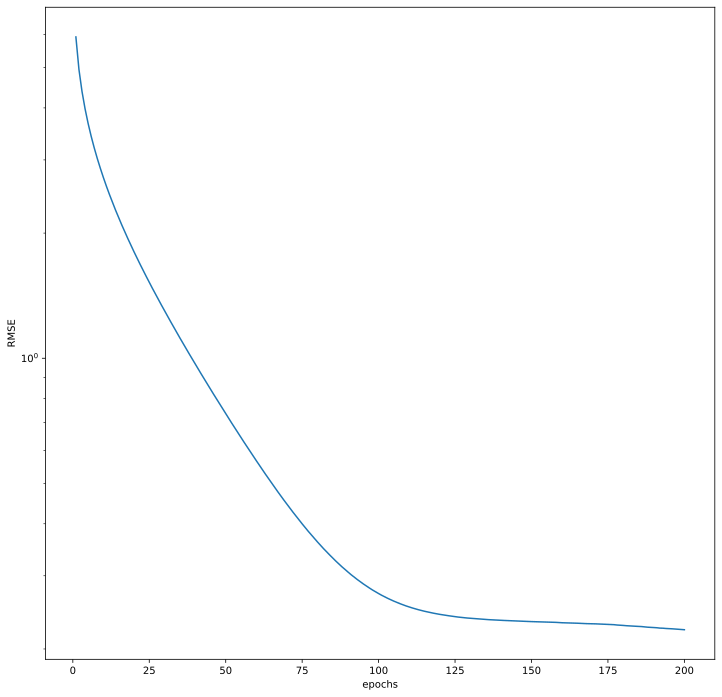

In [77]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)
